In [14]:
import pandas as pd
import numpy as np
from numpy import sin, sign, cos
import pickle
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

from src.features import load_trips


rc = {
    "font.sans-serif": ["Fira Sans Condensed", "Arial"],
    "lines.linewidth": 2.5,
    # "axes.grid": True,
    # "axes.grid.axis": "x",
    "grid.linewidth": 1.5,
    "axes.titleweight": "bold",
    "axes.titlelocation": "left",
    "legend.edgecolor": "none",
    "legend.fontsize": "small",
    "legend.title_fontsize": 0,
    "xtick.bottom": True,
    "axes.edgecolor": ".15",
    "figure.figsize": [8.0, 5.0],
    "axes.spines.bottom": True,
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
}
sns.set_theme( 
    style="whitegrid",
    context="notebook",
    rc=rc
)

pd.set_option('display.max_columns', None)

# Constants
Ci0 = 0.05  # Rolling inertia coefficient
Cd = 0.29  # Air drag coefficient
rho = 1.225  # Density of air
g = 9.81  # Gravitational acceleration
Vwind = 0  # Velocity of wind
A = 2.33  # Cross-sectional area of car
mcar = 1966  # Mass of car
mp = 80  # Mass of passengers
theta = 0  # Road slope


def get_traction_power(V, ux):  # Velocity, x-axis acceleration
    Crr = 0.01 * (1 + V) / 100  # Rolling resistance coefficient

    Fhc = (mcar + mp) * g * sin(theta)  # Hill climbing force
    Faero = sign(V + Vwind) * 1 / 2 * rho * A * Cd * (V + Vwind) ** 2  # Aerodynamic drag
    Fi = Ci0 * (mcar + mp) * ux  # Inertial force
    Frr = sign(V) * (mcar + mp) * g * cos(theta) * Crr  # Rolling resistance force of the wheels

    Ft = Fhc + Faero + Fi + Frr
    # print(Fhc, Faero, Fi, Frr)
    print((Fi / Ft).mean())

    Pt = Ft * V
    return Pt

In [15]:
df = load_trips(["M3_VH"], trips=[7995], sampling='2s')
df_test = load_trips(["M3_VH"], trips=[7448], sampling='2s')

[                            street_name_start   segment_id    GPS_dt  \
TS_or_Distance                                                         
2021-04-26 12:37:16+00:00    Amagermotorvejen     1.205722  0.323416   
2021-04-26 12:37:18+00:00    Amagermotorvejen     6.219565  0.302268   
2021-04-26 12:37:20+00:00    Amagermotorvejen    12.725371  0.306725   
2021-04-26 12:37:22+00:00    Amagermotorvejen    19.297636  0.307778   
2021-04-26 12:37:24+00:00    Amagermotorvejen    25.318275  0.406793   
...                                       ...          ...       ...   
2021-04-26 02:30:56+00:00  Øresundsmotorvejen  9074.433426  0.296934   
2021-04-26 02:30:58+00:00  Øresundsmotorvejen  9081.075992  0.312249   
2021-04-26 02:31:00+00:00  Øresundsmotorvejen  9087.558702  0.296445   
2021-04-26 02:31:02+00:00  Øresundsmotorvejen  9094.166070  0.323487   
2021-04-26 02:31:04+00:00  Øresundsmotorvejen  9100.435827  0.314400   

                             lat_int    lon_int  acceleration_

In [36]:
df = df.query("`pass` == 0")
df_test = df_test.query("`pass` == 0")

In [59]:
# df[["acceleration_y", "acceleration_z", "acceleration_x"]] = df[["acceleration_y", "acceleration_z", "acceleration_x"]] * g
# df_test[["acceleration_y", "acceleration_z", "acceleration_x"]] = df_test[["acceleration_y", "acceleration_z", "acceleration_x"]] * g

C:\Users\s174433\AppData\Local\Temp\ipykernel_12052\3421105359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[["acceleration_y", "acceleration_z", "acceleration_x"]] = df_test[["acceleration_y", "acceleration_z", "acceleration_x"]] * g


In [20]:
# data_dir = "../data/processed"


# def load_trip(routes, trips):
#     dfs = []
#     for route in routes:
#         for trip in trips:
#             df = []
#             for file_path in glob.glob(os.path.join(data_dir, route, f"trip_{trip}_*.pickle")):
#                 with open(file_path, "rb") as f:
#                     df_ = pickle.load(f)
#                 _, trip, i = os.path.splitext(os.path.basename(file_path))[0].split("_")
#                 df_ = df_.assign(trip=trip)\
#                          .assign(route=route)
#             df_ = df_.fillna(np.nan).groupby('segment_id').first().reset_index()
#             df.append(df_)
#         df = pd.concat(df)
#         df = df.fillna(np.nan).groupby('segment_id').first().reset_index()
#         df["obd.trac_cons.value"] = df["obd.trac_cons.value"] - 160
#         dfs.append(df)
#     return pd.concat(dfs)

# df = load_trip(routes=["M3_VH"], trips=[7995])
# df_test = load_trip(routes=["M3_VH"], trips=[7448])

# df[["acc.xyz.x", "acc.xyz.x", "acc.xyz.z"]] = df[["acc.xyz.x", "acc.xyz.y", "acc.xyz.z"]] * g
# df_test[["acc.xyz.x", "acc.xyz.x", "acc.xyz.z"]] = df_test[["acc.xyz.x", "acc.xyz.y", "acc.xyz.z"]] * g

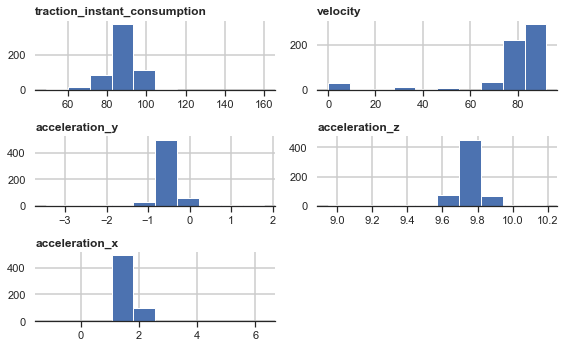

In [60]:
df[["traction_instant_consumption", "velocity", "acceleration_y", "acceleration_z", "acceleration_x"]].hist()
plt.tight_layout()
# plt.gca()

In [71]:
df = (
    df.assign(kW_pred=lambda x: get_traction_power(x["velocity"], x["acceleration_x"]) / 25000)
    .assign(error=lambda x: (x["kW_pred"] - x["traction_instant_consumption"]))
    .assign(abserror=lambda x: np.abs(x["error"]))
)

df_test = (
    df_test.assign(kW_pred=lambda x: get_traction_power(x["velocity"], x["acceleration_x"]) / 25000)
    .assign(error=lambda x: (x["kW_pred"] - x["traction_instant_consumption"]))
    .assign(abserror=lambda x: np.abs(x["error"]))
)

0.1164953123931241
0.25971103519105876


[Text(0.0, 1.0, 'Unsmoothed physical model prediction on test set')]

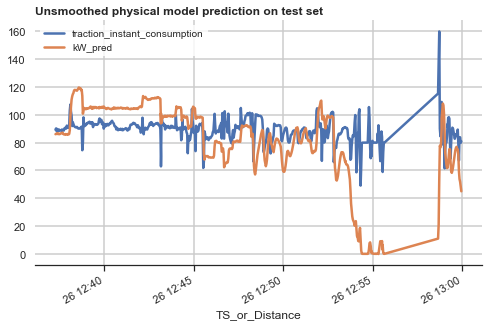

In [62]:
ax = df.plot(y=["traction_instant_consumption", "kW_pred"])
ax.set(title="Unsmoothed physical model prediction on test set")
# ax.hlines(y=0, xmin=-1000, xmax=10000, color=".15", linewidth=1.5)

[Text(0.0, 1.0, 'Physical model prediction on training set')]

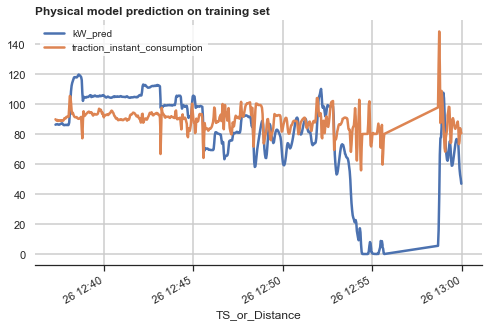

In [72]:
(
df.drop(['route', 'street_name_start'], axis=1)
  .rolling(2).mean()
  .plot(y=["kW_pred", "traction_instant_consumption"])
  .set(title="Physical model prediction on training set")
)

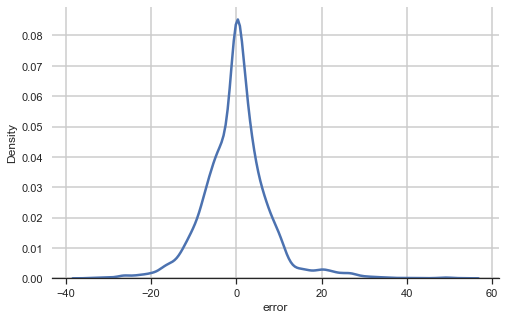

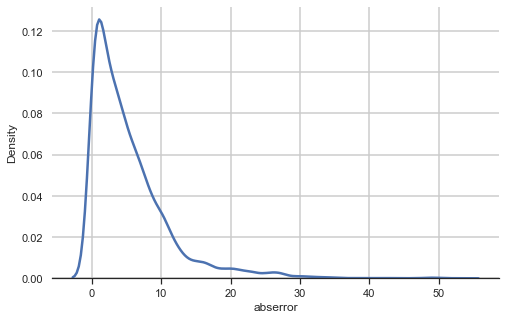

In [27]:
sns.kdeplot(df.error)
plt.show()

sns.kdeplot(df.abserror)
plt.show()

In [28]:
features = ["acc.xyz.x", "acc.xyz.y", "acc.xyz.z",
            "obd.strg_pos.value", "obd.strg_ang.value", "obd.strg_acc.value",
            "obd.acc_yaw.value", "obd.spd.value", "obd.odo.value",
            "obd.ww_f_stat.value", "obd.sb_rem_fl.value", "traffic_lights",
            "road_signs", "speed_limit", "ped_walks", "speed_bumps", "bike_lane", "start_hour"]

target = "error"

In [29]:
import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(df[features], df[target])

LGBMRegressor()

In [30]:
# from sklearn.model_selection import GridSearchCV
# import lightgbm as lgb

# def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
#                        model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
#                        do_probabilities = False):
#     gs = GridSearchCV(
#         estimator=model,
#         param_grid=param_grid, 
#         cv=cv, 
#         n_jobs=-1, 
#         scoring=scoring_fit,
#         verbose=2
#     )
#     fitted_model = gs.fit(X_train_data, y_train_data)

#     if do_probabilities:
#       pred = fitted_model.predict_proba(X_test_data)
#     else:
#       pred = fitted_model.predict(X_test_data)

#     return fitted_model, pred

# model = lgb.LGBMRegressor()
# param_grid = {
#     'n_estimators': [400, 700, 1000],
#     'colsample_bytree': [0.7, 0.8],
#     'max_depth': [15,20,25],
#     'num_leaves': [50, 100, 200],
#     'reg_alpha': [1.1, 1.2, 1.3],
#     'reg_lambda': [1.1, 1.2, 1.3],
#     'min_split_gain': [0.3, 0.4],
#     'subsample': [0.7, 0.8, 0.9],
#     'subsample_freq': [20]
# }

# model, pred = algorithm_pipeline(df[features].to_numpy(), df_test[features].to_numpy(), df[target].to_numpy(), df_test[target].to_numpy(), model, 
#                                  param_grid, cv=5)

# print(model.best_score_)
# print(model.best_params_)

[Text(0.0, 1.0, 'Compound model prediction on training set')]

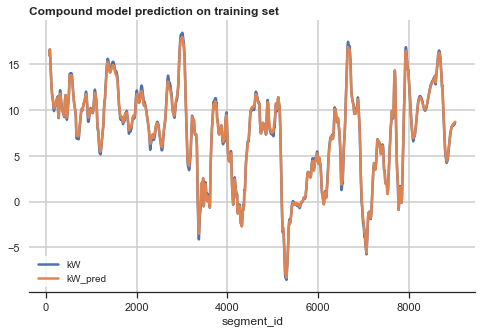

In [31]:
(
df.assign(error_pred=model.predict(df[features]))
  .assign(kW_pred=lambda x: x.kW_pred - x.error_pred)
  .drop(['Date', 'T', 'TS_or_Distance', 'Time', 'route', 'street_name_end', 'street_name_start'], axis=1)
  .rolling(150).mean()
  .plot(x="segment_id", y=["kW", "kW_pred"])
  .set(title="Compound model prediction on training set")
)

-0.35067642154567646


[Text(0.0, 1.0, 'Physical model prediction on test set')]

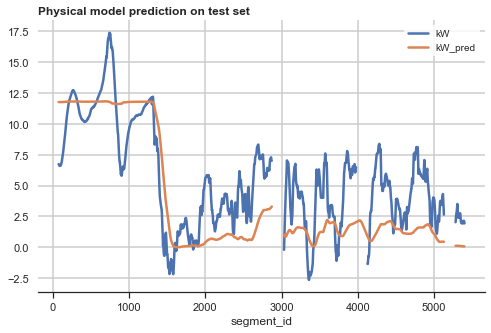

In [32]:
(
df_test
    .assign(kW_pred=lambda x: get_traction_power(x["obd.spd.value"], x["acc.xyz.x"]) / 25000)
    .drop(['Date', 'T', 'TS_or_Distance', 'Time', 'route', 'street_name_end', 'street_name_start'], axis=1)
    .rolling(150).mean()
    .plot(x="segment_id", y=["kW", "kW_pred"])
    .set(title="Physical model prediction on test set")
)

-0.35067642154567646


[Text(0.0, 1.0, 'Compound model prediction on test set')]

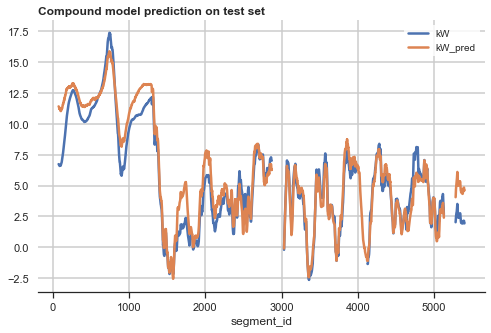

In [33]:
(
df_test.assign(error_pred=model.predict(df_test[features]))
    .assign(kW_pred=lambda x: get_traction_power(x["obd.spd.value"], x["acc.xyz.x"]) / 25000)
    .assign(kW_pred=lambda x: x.kW_pred - x.error_pred)
    .drop(['Date', 'T', 'TS_or_Distance', 'Time', 'route', 'street_name_end', 'street_name_start'], axis=1)
    .rolling(150).mean()
    .plot(x="segment_id", y=["kW", "kW_pred"])
    .set(title="Compound model prediction on test set")
)

Still trying to understand why `acc.xyz.y` has such a huge impact.
However, the impact of `obd.spd.value` is intuitive.
The faster you go, the bigger the effect of road friction, and road friction is one of the two effects (along with the wind) which are not taken into account in the physical model.

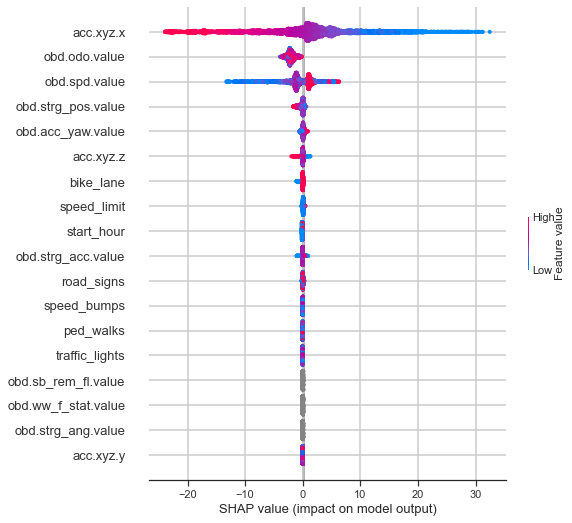

In [34]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_test[features])

shap.summary_plot(shap_values, df_test[features])